# 스테이블 디퓨전을 통한 Textual inversion 미세 조정

스테이블 디퓨전을 통해 단 3~5개의 이미지만으로 새로운 개념을 가르치고, 사용자의 이미지 세트에 맞게 모델을 개인화할 수 있습니다.

## 초기 설정

In [ ]:
!pip install  -U \
  torch==2.0.1 \
  accelerate==0.24.1 \
  transformers==4.35.2 \
  torchvision==0.15.2 \
  diffusers==0.23.1 \
  xformers==0.0.21 \
  bitsandbytes==0.41.1 \
  ftfy \
  tensorboard \
  Jinja2 \
  ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 9.0 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 121.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 114.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.0/167.0 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 54

In [ ]:
# !pip install git+https://github.com/huggingface/diffusers

In [ ]:
# !pip uninstall xformers -y

In [ ]:
# !conda install -y xformers -c xformers

In [ ]:
from accelerate.utils import write_basic_config

write_basic_config()

PosixPath('/root/.cache/huggingface/accelerate/default_config.yaml')

In [ ]:
import argparse
import logging
import math
import os
import random
import shutil
import warnings
from pathlib import Path

import numpy as np
import PIL
import safetensors
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed

from packaging import version
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer

import diffusers
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    DiffusionPipeline,
    DPMSolverMultistepScheduler,
    StableDiffusionPipeline,
    UNet2DConditionModel,
)
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version #, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available

if version.parse(version.parse(PIL.__version__).base_version) >= version.parse("9.1.0"):
    PIL_INTERPOLATION = {
        "linear": PIL.Image.Resampling.BILINEAR,
        "bilinear": PIL.Image.Resampling.BILINEAR,
        "bicubic": PIL.Image.Resampling.BICUBIC,
        "lanczos": PIL.Image.Resampling.LANCZOS,
        "nearest": PIL.Image.Resampling.NEAREST,
    }
else:
    PIL_INTERPOLATION = {
        "linear": PIL.Image.LINEAR,
        "bilinear": PIL.Image.BILINEAR,
        "bicubic": PIL.Image.BICUBIC,
        "lanczos": PIL.Image.LANCZOS,
        "nearest": PIL.Image.NEAREST,
    }
# ------------------------------------------------------------------------------

logger = get_logger(__name__)

In [ ]:
def log_validation(text_encoder, tokenizer, unet, vae, args, accelerator, weight_dtype, epoch):
    logger.info(
        f"Running validation... \n Generating {args.num_validation_images} images with prompt:"
        f" {args.validation_prompt}."
    )
    # 파이프라인 생성 (참고: unet과 vae는 float32로 다시 적재됩니다)
    pipeline = DiffusionPipeline.from_pretrained(
        args.pretrained_model_name_or_path,
        text_encoder=accelerator.unwrap_model(text_encoder),
        tokenizer=tokenizer,
        unet=unet,
        vae=vae,
        safety_checker=None,
        revision=args.revision,
        torch_dtype=weight_dtype,
    )
    pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)
    pipeline = pipeline.to(accelerator.device)
    pipeline.set_progress_bar_config(disable=True)

    # 추론 실행
    generator = None if args.seed is None else torch.Generator(device=accelerator.device).manual_seed(args.seed)
    images = []
    for _ in range(args.num_validation_images):
        with torch.autocast("cuda"):
            image = pipeline(args.validation_prompt, num_inference_steps=25, generator=generator).images[0]
        images.append(image)

    for tracker in accelerator.trackers:
        if tracker.name == "tensorboard":
            np_images = np.stack([np.asarray(img) for img in images])
            tracker.writer.add_images("validation", np_images, epoch, dataformats="NHWC")
        if tracker.name == "wandb":
            tracker.log(
                {
                    "validation": [
                        wandb.Image(image, caption=f"{i}: {args.validation_prompt}") for i, image in enumerate(images)
                    ]
                }
            )

    del pipeline
    torch.cuda.empty_cache()
    return images


def save_progress(text_encoder, placeholder_token_ids, accelerator, args, save_path, safe_serialization=True):
    logger.info("Saving embeddings")
    learned_embeds = (
        accelerator.unwrap_model(text_encoder)
        .get_input_embeddings()
        .weight[min(placeholder_token_ids) : max(placeholder_token_ids) + 1]
    )
    learned_embeds_dict = {args.placeholder_token: learned_embeds.detach().cpu()}

    if safe_serialization:
        safetensors.torch.save_file(learned_embeds_dict, save_path, metadata={"format": "pt"})
    else:
        torch.save(learned_embeds_dict, save_path)


In [ ]:
parser = argparse.ArgumentParser()

parser.add_argument(
    "--save_steps",
    type=int,
    default=500,
    help="Save learned_embeds.bin every X updates steps.",
)
parser.add_argument(
    "--save_as_full_pipeline",
    action="store_true",
    help="Save the complete stable diffusion pipeline.",
)
parser.add_argument(
    "--num_vectors",
    type=int,
    default=1,
    help="How many textual inversion vectors shall be used to learn the concept.",
)
parser.add_argument(
    "--pretrained_model_name_or_path",
    type=str,
    default="runwayml/stable-diffusion-v1-5",
    help="Path to pretrained model or model identifier from huggingface.co/models.",
)
parser.add_argument(
    "--revision",
    type=str,
    default=None,
    required=False,
    help="Revision of pretrained model identifier from huggingface.co/models.",
)
parser.add_argument(
    "--tokenizer_name",
    type=str,
    default=None,
    help="Pretrained tokenizer name or path if not the same as model_name",
)
parser.add_argument(
    "--train_data_dir",
    type=str,
    default="images_molly/",
    help="A folder containing the training data."
)
parser.add_argument(
    "--placeholder_token",
    type=str,
    default="M*",
    help="A token to use as a placeholder for the concept.",
)
parser.add_argument(
    "--initializer_token",
    type=str,
    default="dog",
    required=False,
    help="A token to use as initializer word."
)
parser.add_argument("--learnable_property",
                    type=str,
                    default="object",
                    help="Choose between 'object' and 'style'")
parser.add_argument("--repeats",
                    type=int,
                    default=100,
                    help="How many times to repeat the training data.")
parser.add_argument(
    "--output_dir",
    type=str,
    default="textual_inversion_model",
    help="The output directory where the model predictions and checkpoints will be written.",
)
parser.add_argument("--seed",
                    type=int,
                    default=None,
                    help="A seed for reproducible training.")
parser.add_argument(
    "--resolution",
    type=int,
    default=512,
    help=(
        "The resolution for input images, all the images in the train/validation dataset will be resized to this"
        " resolution"
    ),
)
parser.add_argument(
    "--center_crop", action="store_true", help="Whether to center crop images before resizing to resolution."
)
parser.add_argument(
    "--train_batch_size", type=int, default=1, help="Batch size (per device) for the training dataloader."
)
parser.add_argument("--num_train_epochs", type=int, default=100)
parser.add_argument(
    "--max_train_steps",
    type=int,
    default=200,
    help="Total number of training steps to perform.  If provided, overrides num_train_epochs.",
)
parser.add_argument(
    "--gradient_accumulation_steps",
    type=int,
    default=4,
    help="Number of updates steps to accumulate before performing a backward/update pass.",
)
parser.add_argument(
    "--gradient_checkpointing",
    action="store_true",
    help="Whether or not to use gradient checkpointing to save memory at the expense of slower backward pass.",
)
parser.add_argument(
    "--learning_rate",
    type=float,
    default=5e-4,
    help="Initial learning rate (after the potential warmup period) to use.",
)
parser.add_argument(
    "--scale_lr",
    action="store_true",
    default=False,
    help="Scale the learning rate by the number of GPUs, gradient accumulation steps, and batch size.",
)
parser.add_argument(
    "--lr_scheduler",
    type=str,
    default="constant",
    help=(
        'The scheduler type to use. Choose between ["linear", "cosine", "cosine_with_restarts", "polynomial",'
        ' "constant", "constant_with_warmup"]'
    ),
)
parser.add_argument(
    "--lr_warmup_steps",
    type=int,
    default=0,
    help="Number of steps for the warmup in the lr scheduler."
)
parser.add_argument(
    "--lr_num_cycles",
    type=int,
    default=1,
    help="Number of hard resets of the lr in cosine_with_restarts scheduler.",
)
parser.add_argument(
    "--dataloader_num_workers",
    type=int,
    default=0,
    help=(
        "Number of subprocesses to use for data loading. 0 means that the data will be loaded in the main process."
    ),
)
parser.add_argument("--adam_beta1", type=float, default=0.9, help="The beta1 parameter for the Adam optimizer.")
parser.add_argument("--adam_beta2", type=float, default=0.999, help="The beta2 parameter for the Adam optimizer.")
parser.add_argument("--adam_weight_decay", type=float, default=1e-2, help="Weight decay to use.")
parser.add_argument("--adam_epsilon", type=float, default=1e-08, help="Epsilon value for the Adam optimizer")

parser.add_argument(
    "--logging_dir",
    type=str,
    default="logs",
    help=(
        "[TensorBoard](https://www.tensorflow.org/tensorboard) log directory. Will default to"
        " *output_dir/runs/**CURRENT_DATETIME_HOSTNAME***."
    ),
)
parser.add_argument(
    "--mixed_precision",
    type=str,
    default="no",
    choices=["no", "fp16", "bf16"],
    help=(
        "Whether to use mixed precision. Choose"
        "between fp16 and bf16 (bfloat16). Bf16 requires PyTorch >= 1.10."
        "and an Nvidia Ampere GPU."
    ),
)
parser.add_argument(
    "--allow_tf32",
    action="store_true",
    help=(
        "Whether or not to allow TF32 on Ampere GPUs. Can be used to speed up training. For more information, see"
        " https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices"
    ),
)
parser.add_argument(
    "--report_to",
    type=str,
    default="tensorboard",
    help=(
        'The integration to report the results and logs to. Supported platforms are `"tensorboard"`'
        ' (default), `"wandb"` and `"comet_ml"`. Use `"all"` to report to all integrations.'
    ),
)
parser.add_argument(
    "--validation_prompt",
    type=str,
    default=None,
    help="A prompt that is used during validation to verify that the model is learning.",
)
parser.add_argument(
    "--num_validation_images",
    type=int,
    default=4,
    help="Number of images that should be generated during validation with `validation_prompt`.",
)
parser.add_argument(
    "--validation_steps",
    type=int,
    default=100,
    help=(
        "Run validation every X steps. Validation consists of running the prompt"
        " `args.validation_prompt` multiple times: `args.num_validation_images`"
        " and logging the images."
    ),
)
parser.add_argument(
    "--validation_epochs",
    type=int,
    default=None,
    help=(
        "Deprecated in favor of validation_steps. Run validation every X epochs. Validation consists of running the prompt"
        " `args.validation_prompt` multiple times: `args.num_validation_images`"
        " and logging the images."
    ),
)
parser.add_argument("--local_rank", type=int, default=-1, help="For distributed training: local_rank")
parser.add_argument(
    "--checkpointing_steps",
    type=int,
    default=500,
    help=(
        "Save a checkpoint of the training state every X updates. These checkpoints are only suitable for resuming"
        " training using `--resume_from_checkpoint`."
    ),
)
parser.add_argument(
    "--checkpoints_total_limit",
    type=int,
    default=None,
    help=("Max number of checkpoints to store."),
)
parser.add_argument(
    "--resume_from_checkpoint",
    type=str,
    default=None,
    help=(
        "Whether training should be resumed from a previous checkpoint. Use a path saved by"
        ' `--checkpointing_steps`, or `"latest"` to automatically select the last available checkpoint.'
    ),
)
parser.add_argument(
    "--enable_xformers_memory_efficient_attention", action="store_true", help="Whether or not to use xformers."
)
parser.add_argument(
    "--no_safe_serialization",
    action="store_true",
    help="If specified save the checkpoint not in `safetensors` format, but in original PyTorch format instead.",
)

args, _ = parser.parse_known_args()

env_local_rank = int(os.environ.get("LOCAL_RANK", -1))
if env_local_rank != -1 and env_local_rank != args.local_rank:
    args.local_rank = env_local_rank

if args.train_data_dir is None:
    raise ValueError("You must specify a train data directory.")

print(args)

Namespace(save_steps=500, save_as_full_pipeline=False, num_vectors=1, pretrained_model_name_or_path='runwayml/stable-diffusion-v1-5', revision=None, tokenizer_name=None, train_data_dir='images_molly/', placeholder_token='M*', initializer_token='dog', learnable_property='object', repeats=100, output_dir='textual_inversion_model', seed=None, resolution=512, center_crop=False, train_batch_size=1, num_train_epochs=100, max_train_steps=200, gradient_accumulation_steps=4, gradient_checkpointing=False, learning_rate=0.0005, scale_lr=False, lr_scheduler='constant', lr_warmup_steps=0, lr_num_cycles=1, dataloader_num_workers=0, adam_beta1=0.9, adam_beta2=0.999, adam_weight_decay=0.01, adam_epsilon=1e-08, logging_dir='logs', mixed_precision='no', allow_tf32=False, report_to='tensorboard', validation_prompt=None, num_validation_images=4, validation_steps=100, validation_epochs=None, local_rank=-1, checkpointing_steps=500, checkpoints_total_limit=None, resume_from_checkpoint=None, enable_xformers_m

In [ ]:
imagenet_templates_small = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

imagenet_style_templates_small = [
    "a painting in the style of {}",
    "a rendering in the style of {}",
    "a cropped painting in the style of {}",
    "the painting in the style of {}",
    "a clean painting in the style of {}",
    "a dirty painting in the style of {}",
    "a dark painting in the style of {}",
    "a picture in the style of {}",
    "a cool painting in the style of {}",
    "a close-up painting in the style of {}",
    "a bright painting in the style of {}",
    "a cropped painting in the style of {}",
    "a good painting in the style of {}",
    "a close-up painting in the style of {}",
    "a rendition in the style of {}",
    "a nice painting in the style of {}",
    "a small painting in the style of {}",
    "a weird painting in the style of {}",
    "a large painting in the style of {}",
]


class TextualInversionDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        learnable_property="object",  # [object, style]
        size=512,
        repeats=100,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
        placeholder_token="*",
        center_crop=False,
    ):
        self.data_root = data_root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.size = size
        self.placeholder_token = placeholder_token
        self.center_crop = center_crop
        self.flip_p = flip_p

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)]

        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == "train":
            self._length = self.num_images * repeats

        self.interpolation = {
            "linear": PIL_INTERPOLATION["linear"],
            "bilinear": PIL_INTERPOLATION["bilinear"],
            "bicubic": PIL_INTERPOLATION["bicubic"],
            "lanczos": PIL_INTERPOLATION["lanczos"],
        }[interpolation]

        self.templates = imagenet_style_templates_small if learnable_property == "style" else imagenet_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        image = Image.open(self.image_paths[i % self.num_images])

        if not image.mode == "RGB":
            image = image.convert("RGB")

        placeholder_string = self.placeholder_token
        text = random.choice(self.templates).format(placeholder_string)

        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        # 기본적으로 확률 미분 방정식을 통한 점수 기반 생성 모델링(Score-based Generative Modeling through Stochastic Differential Equations; score-sde) 전처리 사용
        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            (
                h,
                w,
            ) = (
                img.shape[0],
                img.shape[1],
            )
            img = img[(h - crop) // 2 : (h + crop) // 2, (w - crop) // 2 : (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        return example

In [ ]:
logging_dir = os.path.join(args.output_dir, args.logging_dir)
accelerator_project_config = ProjectConfiguration(project_dir=args.output_dir, logging_dir=logging_dir)
accelerator = Accelerator(
    gradient_accumulation_steps=args.gradient_accumulation_steps,
    mixed_precision=args.mixed_precision,
    log_with=args.report_to,
    project_config=accelerator_project_config,
)

# if args.report_to == "wandb":
#     if not is_wandb_available():
#         raise ImportError("Make sure to install wandb if you want to use it for logging during training.")

# 각 과정마다 디버깅을 위한 설정 로그를 남기기
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger.info(accelerator.state, main_process_only=False)
if accelerator.is_local_main_process:
    transformers.utils.logging.set_verbosity_warning()
    diffusers.utils.logging.set_verbosity_info()
else:
    transformers.utils.logging.set_verbosity_error()
    diffusers.utils.logging.set_verbosity_error()

# 전달된 경우, 훈련 시드를 설정
if args.seed is not None:
    set_seed(args.seed)

# 저장소 생성 처리
if accelerator.is_main_process:
    if args.output_dir is not None:
        os.makedirs(args.output_dir, exist_ok=True)

# 토크나이저 적재
if args.tokenizer_name:
    tokenizer = CLIPTokenizer.from_pretrained(args.tokenizer_name)
elif args.pretrained_model_name_or_path:
    tokenizer = CLIPTokenizer.from_pretrained(args.pretrained_model_name_or_path, subfolder="tokenizer")

# 스케줄러와 모델 적재
noise_scheduler = DDPMScheduler.from_pretrained(args.pretrained_model_name_or_path, subfolder="scheduler")
text_encoder = CLIPTextModel.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="text_encoder", revision=args.revision
)
vae = AutoencoderKL.from_pretrained(args.pretrained_model_name_or_path, subfolder="vae", revision=args.revision)
unet = UNet2DConditionModel.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="unet", revision=args.revision
)

# 토크나이저에 placeholder token 추가
placeholder_tokens = [args.placeholder_token]

if args.num_vectors < 1:
    raise ValueError(f"--num_vectors has to be larger or equal to 1, but is {args.num_vectors}")

# 다중 벡터를 위한 더미 토큰 추가
additional_tokens = []
for i in range(1, args.num_vectors):
    additional_tokens.append(f"{args.placeholder_token}_{i}")
placeholder_tokens += additional_tokens

num_added_tokens = tokenizer.add_tokens(placeholder_tokens)
if num_added_tokens != args.num_vectors:
    raise ValueError(
        f"The tokenizer already contains the token {args.placeholder_token}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )

# initializer_token과 placeholder_token을 token_ids로 전환
token_ids = tokenizer.encode(args.initializer_token, add_special_tokens=False)
# initializer_token이 단일 토큰인지 시퀀스 토큰인지 확인
if len(token_ids) > 1:
    raise ValueError("The initializer token must be a single token.")

initializer_token_id = token_ids[0]
placeholder_token_ids = tokenizer.convert_tokens_to_ids(placeholder_tokens)

# 새로운 special 토큰을 토크나이저에 추가하여 토큰 임베딩의 크기 조정
text_encoder.resize_token_embeddings(len(tokenizer))
초기화 토큰의 임베딩으로 새로 추가된 플레이스홀더 토큰을 초기화합니다.

# initializer 토큰의 임베딩으로 추가된 placeholder 토큰을 초기화
token_embeds = text_encoder.get_input_embeddings().weight.data
with torch.no_grad():
    for token_id in placeholder_token_ids:
        token_embeds[token_id] = token_embeds[initializer_token_id].clone()

# 변형 자동 인코더(vae)와 U-Net 고정시키기
vae.requires_grad_(False)
unet.requires_grad_(False)
# 텍스트 인코더에서 토큰 임베딩을 제외한 모든 파라미터를 고정시키기
text_encoder.text_model.encoder.requires_grad_(False)
text_encoder.text_model.final_layer_norm.requires_grad_(False)
text_encoder.text_model.embeddings.position_embedding.requires_grad_(False)

if args.gradient_checkpointing:
    # 메모리를 절약하기 위해 그래디언트 체크포인팅을 사용하면 훈련 모드로 U-Net을 유지
    # dropout이 0이 아니므로 평가 모드나 훈련 모드인지는 상관없습니다.
    unet.train()
    text_encoder.gradient_checkpointing_enable()
    unet.enable_gradient_checkpointing()

if args.enable_xformers_memory_efficient_attention:
    if is_xformers_available():
        import xformers

        xformers_version = version.parse(xformers.__version__)
        if xformers_version == version.parse("0.0.16"):
            logger.warn(
                "xFormers 0.0.16 cannot be used for training in some GPUs. If you observe problems during training, please update xFormers to at least 0.0.17. See https://huggingface.co/docs/diffusers/main/en/optimization/xformers for more details."
            )
        unet.enable_xformers_memory_efficient_attention()
    else:
        raise ValueError("xformers is not available. Make sure it is installed correctly")

# Ampere GPU로 더 빠른 훈련을 위해 TF32를 활성화,
# 자세한 내용은 https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices를 참조
if args.allow_tf32:
    torch.backends.cuda.matmul.allow_tf32 = True

if args.scale_lr:
    args.learning_rate = (
        args.learning_rate * args.gradient_accumulation_steps * args.train_batch_size * accelerator.num_processes
    )

# 옵티마이저 초기화
optimizer = torch.optim.AdamW(
    text_encoder.get_input_embeddings().parameters(),  # 오직 임베딩만을 최적화
    lr=args.learning_rate,
    betas=(args.adam_beta1, args.adam_beta2),
    weight_decay=args.adam_weight_decay,
    eps=args.adam_epsilon,
)

# 데이터 세트 및 데이터 로더 생성
train_dataset = TextualInversionDataset(
    data_root=args.train_data_dir,
    tokenizer=tokenizer,
    size=args.resolution,
    placeholder_token=(" ".join(tokenizer.convert_ids_to_tokens(placeholder_token_ids))),
    repeats=args.repeats,
    learnable_property=args.learnable_property,
    center_crop=args.center_crop,
    set="train",
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.train_batch_size, shuffle=True, num_workers=args.dataloader_num_workers
)
if args.validation_epochs is not None:
    warnings.warn(
        f"FutureWarning: You are doing logging with validation_epochs={args.validation_epochs}."
        " Deprecated validation_epochs in favor of `validation_steps`"
        f"Setting `args.validation_steps` to {args.validation_epochs * len(train_dataset)}",
        FutureWarning,
        stacklevel=2,
    )
    args.validation_steps = args.validation_epochs * len(train_dataset)

# 스케줄러와 훈련 단계 수에 대한 수학적 처리.
overrode_max_train_steps = False
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
if args.max_train_steps is None:
    args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
    overrode_max_train_steps = True

lr_scheduler = get_scheduler(
    args.lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=args.lr_warmup_steps * accelerator.num_processes,
    num_training_steps=args.max_train_steps * accelerator.num_processes,
    num_cycles=args.lr_num_cycles,
)

# `가속기`로 모든 것을 준비합니다.
text_encoder, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    text_encoder, optimizer, train_dataloader, lr_scheduler
)

# 혼합 정밀도로 훈련하기 위해 모든 고정되는 가중치(변형 자동 인코더, 저순위 적응(lora)이 아닌 text_encoder와 저순위 적응(lora)이 아닌 U-Net)를 반 정밀도로 변환.
# 이러한 가중치는 추론에만 사용되므로, 완전 정밀도로 유지할 필요가 없습니다.
weight_dtype = torch.float32
if accelerator.mixed_precision == "fp16":
    weight_dtype = torch.float16
elif accelerator.mixed_precision == "bf16":
    weight_dtype = torch.bfloat16

# 변형 자동 인코더(vae)와 U-Net을 장치(device)에 불러서 weight_dtype로 변환.
unet.to(accelerator.device, dtype=weight_dtype)
vae.to(accelerator.device, dtype=weight_dtype)

# 훈련 데이터 로더 크기가 변경되었을 수 있으므로 총 훈련 단계를 다시 계산합니다.
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
if overrode_max_train_steps:
    args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch

# 훈련 단계 계산 후에 훈련 에포크(epoch) 수 다시 계산합니다.
args.num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

# 사용할 추적기를 초기화하고 설정 저장합니다.
# 추적기는 메인 프로세스에서 자동으로 초기화합니다.
if accelerator.is_main_process:
    accelerator.init_trackers("textual_inversion", config=vars(args))

# 훈련 시작!
total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

logger.info("***** Running training *****")
logger.info(f"  Num examples = {len(train_dataset)}")
logger.info(f"  Num Epochs = {args.num_train_epochs}")
logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
logger.info(f"  Total optimization steps = {args.max_train_steps}")
global_step = 0
first_epoch = 0

# 이전에 저장된 가중치와 상태 적재.
if args.resume_from_checkpoint:
    if args.resume_from_checkpoint != "latest":
        path = os.path.basename(args.resume_from_checkpoint)
    else:
        # 최근 체크포인트 적재
        dirs = os.listdir(args.output_dir)
        dirs = [d for d in dirs if d.startswith("checkpoint")]
        dirs = sorted(dirs, key=lambda x: int(x.split("-")[1]))
        path = dirs[-1] if len(dirs) > 0 else None

    if path is None:
        accelerator.print(
            f"Checkpoint '{args.resume_from_checkpoint}' does not exist. Starting a new training run."
        )
        args.resume_from_checkpoint = None
    else:
        accelerator.print(f"Resuming from checkpoint {path}")
        accelerator.load_state(os.path.join(args.output_dir, path))
        global_step = int(path.split("-")[1])

        resume_global_step = global_step * args.gradient_accumulation_steps
        first_epoch = global_step // num_update_steps_per_epoch
        resume_step = resume_global_step % (num_update_steps_per_epoch * args.gradient_accumulation_steps)

# 각 장치에 진행 표시줄을 한 번만 표시.
progress_bar = tqdm(range(global_step, args.max_train_steps), disable=not accelerator.is_local_main_process)
progress_bar.set_description("Steps")

# 참조용으로 원래 임베딩 유지.
orig_embeds_params = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight.data.clone()

for epoch in range(first_epoch, args.num_train_epochs):
    text_encoder.train()
    for step, batch in enumerate(train_dataloader):
        # 재개된 단계에 도달할 때까지 훈련 단계를 건너뛰기.
        if args.resume_from_checkpoint and epoch == first_epoch and step < resume_step:
            if step % args.gradient_accumulation_steps == 0:
                progress_bar.update(1)
            continue

        with accelerator.accumulate(text_encoder):
            # 이미지를 잠재 공간으로 변환
            latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample().detach()
            latents = latents * vae.config.scaling_factor

            # 잠재 공간에 추가될 노이즈를 샘플링
            noise = torch.randn_like(latents)
            bsz = latents.shape[0]
            # 각 이미지마다 무작위로 타임스텝을 샘플링
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
            timesteps = timesteps.long()

            # 각 타임스텝의 노이즈 크기에 따라 잠재 공간에 노이즈를 추가
            # (이것이 순방향 확산 과정)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # 조건부 텍스트 임베딩 적재
            encoder_hidden_states = text_encoder(batch["input_ids"])[0].to(dtype=weight_dtype)

            # 노이즈 잔여값을 예측
            model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

            # 예측 유형에 따라 손실 목표를 설정
            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(latents, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

            loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

            accelerator.backward(loss)

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            # 새로 추가된 토큰 외에는 임베딩 가중치가 업데이트되지 않도록 한다.
            index_no_updates = torch.ones((len(tokenizer),), dtype=torch.bool)
            index_no_updates[min(placeholder_token_ids) : max(placeholder_token_ids) + 1] = False

            with torch.no_grad():
                accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[
                    index_no_updates
                ] = orig_embeds_params[index_no_updates]

        # 가속기가 뒤에서 최적화 단계를 수행했는지 확인
        if accelerator.sync_gradients:
            images = []
            progress_bar.update(1)
            global_step += 1
            if global_step % args.save_steps == 0:
                weight_name = (
                    f"learned_embeds-steps-{global_step}.bin"
                    if args.no_safe_serialization
                    else f"learned_embeds-steps-{global_step}.safetensors"
                )
                save_path = os.path.join(args.output_dir, weight_name)
                save_progress(
                    text_encoder,
                    placeholder_token_ids,
                    accelerator,
                    args,
                    save_path,
                    safe_serialization=not args.no_safe_serialization,
                )

            if accelerator.is_main_process:
                if global_step % args.checkpointing_steps == 0:
                    # 상태를 저장하기 전에, 해당 저장 단계에서 `checkpoints_total_limit`을 초과하는지 확인
                    if args.checkpoints_total_limit is not None:
                        checkpoints = os.listdir(args.output_dir)
                        checkpoints = [d for d in checkpoints if d.startswith("checkpoint")]
                        checkpoints = sorted(checkpoints, key=lambda x: int(x.split("-")[1]))

                        # 새로운 체크포인트를 저장하기 전에, 체크포인트 수가 `checkpoints_total_limit - 1`개 이하이어야 한다.
                        if len(checkpoints) >= args.checkpoints_total_limit:
                            num_to_remove = len(checkpoints) - args.checkpoints_total_limit + 1
                            removing_checkpoints = checkpoints[0:num_to_remove]

                            logger.info(
                                f"{len(checkpoints)} checkpoints already exist, removing {len(removing_checkpoints)} checkpoints"
                            )
                            logger.info(f"removing checkpoints: {', '.join(removing_checkpoints)}")

                            for removing_checkpoint in removing_checkpoints:
                                removing_checkpoint = os.path.join(args.output_dir, removing_checkpoint)
                                shutil.rmtree(removing_checkpoint)

                    save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                    accelerator.save_state(save_path)
                    logger.info(f"Saved state to {save_path}")

                if args.validation_prompt is not None and global_step % args.validation_steps == 0:
                    images = log_validation(
                        text_encoder, tokenizer, unet, vae, args, accelerator, weight_dtype, epoch
                    )

        logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
        progress_bar.set_postfix(**logs)
        accelerator.log(logs, step=global_step)

        if global_step >= args.max_train_steps:
            break


# 학습된 모듈로 파이프라인을 생성하고 저장.
accelerator.wait_for_everyone()

save_full_model = args.save_as_full_pipeline

if save_full_model:
    pipeline = StableDiffusionPipeline.from_pretrained(
        args.pretrained_model_name_or_path,
        text_encoder=accelerator.unwrap_model(text_encoder),
        vae=vae,
        unet=unet,
        tokenizer=tokenizer,
    )
    pipeline.save_pretrained(args.output_dir)
# 새로 학습된 임베딩을 저장
weight_name = "learned_embeds.bin" if args.no_safe_serialization else "learned_embeds.safetensors"
save_path = os.path.join(args.output_dir, weight_name)
save_progress(
    text_encoder,
    placeholder_token_ids,
    accelerator,
    args,
    save_path,
    safe_serialization=not args.no_safe_serialization,
)

accelerator.end_training()

{'sample_max_value', 'thresholding', 'timestep_spacing', 'prediction_type', 'dynamic_thresholding_ratio', 'clip_sample_range', 'variance_type'} was not found in config. Values will be initialized to default values.
{'scaling_factor', 'force_upcast'} was not found in config. Values will be initialized to default values.
{'attention_type', 'num_attention_heads', 'addition_embed_type', 'projection_class_embeddings_input_dim', 'dropout', 'upcast_attention', 'time_embedding_act_fn', 'resnet_time_scale_shift', 'use_linear_projection', 'encoder_hid_dim', 'only_cross_attention', 'addition_time_embed_dim', 'transformer_layers_per_block', 'conv_out_kernel', 'class_embed_type', 'mid_block_only_cross_attention', 'num_class_embeds', 'cross_attention_norm', 'encoder_hid_dim_type', 'time_embedding_dim', 'reverse_transformer_layers_per_block', 'time_cond_proj_dim', 'addition_embed_type_num_heads', 'class_embeddings_concat', 'mid_block_type', 'time_embedding_type', 'conv_in_kernel', 'timestep_post_act'

  0%|          | 0/200 [00:00<?, ?it/s]

## 추론 수행

다음으로, 학습된 임베딩과 'M*' 학습된 토큰을 포함한 프롬프트를 활용하여 추론을 수행할 수 있습니다.

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16).to("cuda")

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

{'requires_safety_checker'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

{'scaling_factor', 'force_upcast'} was not found in config. Values will be initialized to default values.
Loaded vae as AutoencoderKL from `vae` subfolder of runwayml/stable-diffusion-v1-5.
Loaded text_encoder as CLIPTextModel from `text_encoder` subfolder of runwayml/stable-diffusion-v1-5.
Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of runwayml/stable-diffusion-v1-5.
{'attention_type', 'num_attention_heads', 'addition_embed_type', 'projection_class_embeddings_input_dim', 'dropout', 'upcast_attention', 'time_embedding_act_fn', 'resnet_time_scale_shift', 'use_linear_projection', 'encoder_hid_dim', 'only_cross_attention', 'addition_time_embed_dim', 'transformer_layers_per_block', 'conv_out_kernel', 'class_embed_type', 'mid_block_only_cross_attention', 'num_class_embeds', 'cross_attention_norm', 'encoder_hid_dim_type', 'time_embedding_dim', 'reverse_transformer_layers_per_block', 'time_cond_proj_dim', 'addition_embed_type_num_heads', 'class_embeddings_concat', 'mid_block_

In [ ]:
pipe.load_textual_inversion("./textual_inversion_model", token="M*")

Loaded textual inversion embedding for M*.


In [ ]:
prompt = "An oil painting of M*"

image = pipe(prompt, num_inference_steps=50).images[0]
image.save("output/molly-dog3.png")

  0%|          | 0/50 [00:00<?, ?it/s]

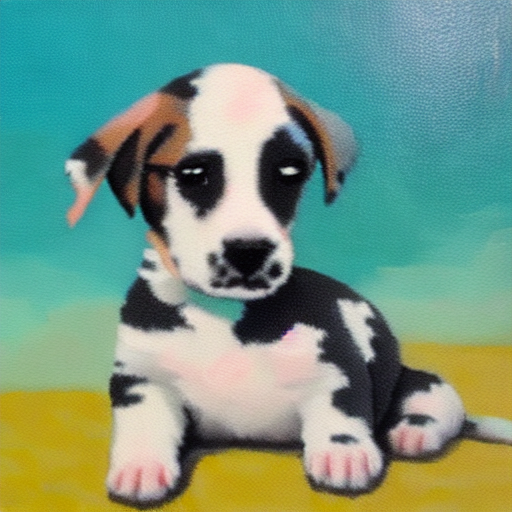

In [ ]:
from IPython.display import Image
Image("./output/molly-dog3.png")

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16).to("cuda")

{'requires_safety_checker'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

{'scaling_factor', 'force_upcast'} was not found in config. Values will be initialized to default values.
Loaded vae as AutoencoderKL from `vae` subfolder of runwayml/stable-diffusion-v1-5.
Loaded text_encoder as CLIPTextModel from `text_encoder` subfolder of runwayml/stable-diffusion-v1-5.
Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of runwayml/stable-diffusion-v1-5.
{'attention_type', 'num_attention_heads', 'addition_embed_type', 'projection_class_embeddings_input_dim', 'dropout', 'upcast_attention', 'time_embedding_act_fn', 'resnet_time_scale_shift', 'use_linear_projection', 'encoder_hid_dim', 'only_cross_attention', 'addition_time_embed_dim', 'transformer_layers_per_block', 'conv_out_kernel', 'class_embed_type', 'mid_block_only_cross_attention', 'num_class_embeds', 'cross_attention_norm', 'encoder_hid_dim_type', 'time_embedding_dim', 'reverse_transformer_layers_per_block', 'time_cond_proj_dim', 'addition_embed_type_num_heads', 'class_embeddings_concat', 'mid_block_

In [ ]:
pipe.load_textual_inversion("./textual_inversion_model", token="M*")

Loaded textual inversion embedding for M*.


In [ ]:
prompt = "An oil painting of M*"

image = pipe(prompt, num_inference_steps=50).images[0]
image.save("output/molly-dog3.png")

  0%|          | 0/50 [00:00<?, ?it/s]

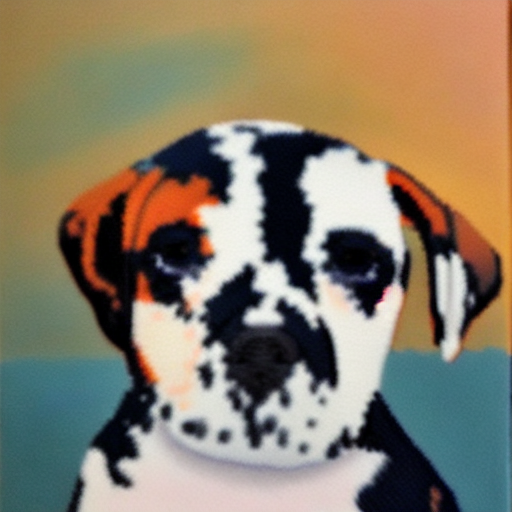

In [ ]:
from IPython.display import Image
Image("./output/molly-dog3.png")